# Bikesharing Dataset
## Andrea Di Simone
----

# Table of Contents <a class="anchor" id="TOC"></a>

* [Setting up the environment](#environment)
* [Steering the execution](#steering)
* [Reading and inspecting the inputs](#reading)
  * [Preparation of data](#preparation)
  * [Check data after manipulation](#check)
  * [Creating training and test sets](#creating)
* [Model fitting](#model)
* [Inspection of results](#inspection)
* [Comments](#comments)


# Setting up the environment <a class="anchor" id="environment"></a>

Some relevant imports are executed here. The plot style is also chosen, and interactive plotting is selected.

[to top](#TOC)

In [26]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import ensemble

from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn import svm

from sklearn.decomposition import PCA


from collections import defaultdict


# table formatting
from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# set interactive plotting on
plt.ion()

plt.rc('text', usetex=True)

# Steering the execution <a class="anchor" id="steering"></a>
In the following cell, one can choose which regression algorithms need to be trained and evaluated.
The `models` dictionary maps a list of names (free text) to the model implementation in sklearn and its arguments.
The input csv file is defined in the `input_file` variable, and `max_percentage` is the maximum fraction of entries to be used for training.

[to top](#TOC)

In [101]:

models={
    
#    'KNeighborsRegressor':[neighbors.KNeighborsRegressor,{'weights':'distance','n_neighbors':5}],
#    'Linear Regression':[linear_model.LinearRegression,{'copy_X':True}],
#    'BDT':[ensemble.RandomForestRegressor,{'n_estimators':100}],
#    'Ridge':[linear_model.Ridge,{'copy_X':True}],
#    'Ridge2':[linear_model.Ridge,{'copy_X':True,'alpha':2.0}],
#    'Lasso':[linear_model.Lasso,{}],
#    'Lasso2':[linear_model.Lasso,{'alpha':2.0}],
    'MLPRegressor':[neural_network.MLPRegressor,{}], 
    'MLPRegressor2':[neural_network.MLPRegressor,{'hidden_layer_sizes': (100,50)}], 

#    'SVR':[svm.SVR,{}]
}

input_file = "hour.csv"

max_percentage=30

# Reading/inspecting the inputs <a class="anchor" id="reading"></a>
The following code reads the csv file in a `DataFrame` and plots the variables, both as a function of time and as histograms.

[to top](#TOC)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff82459d4d0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7ff88307a250>]], dtype=object)

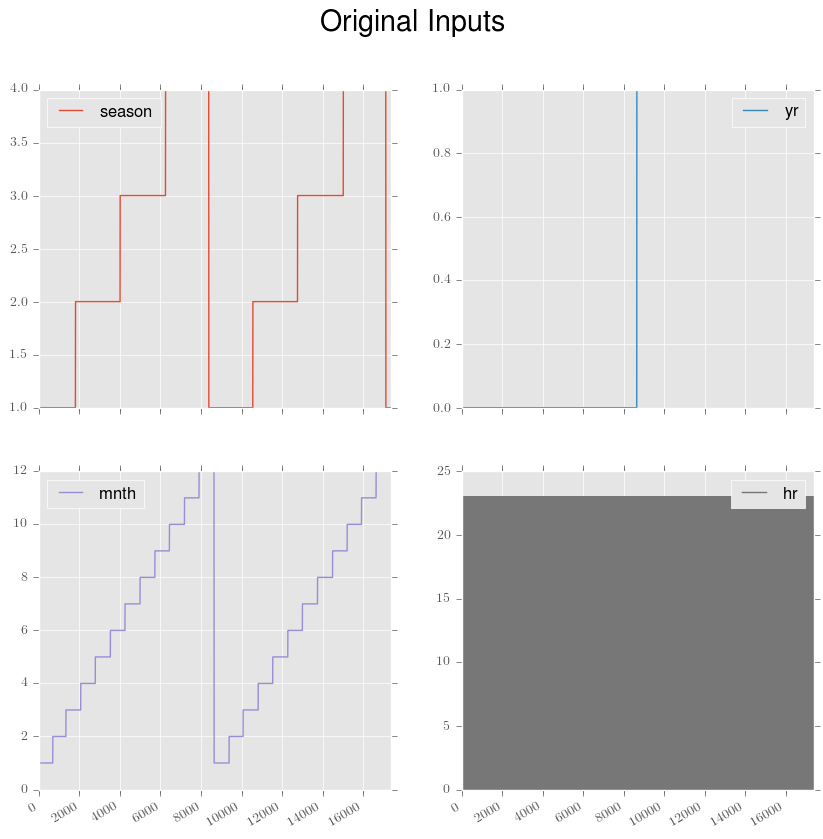

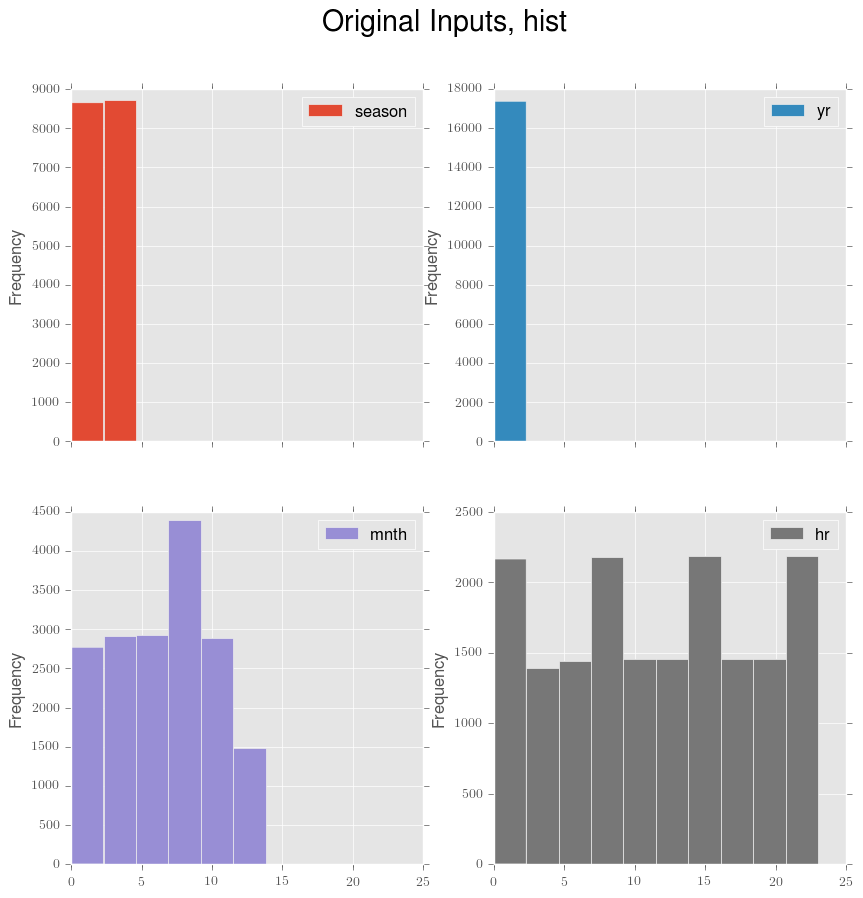

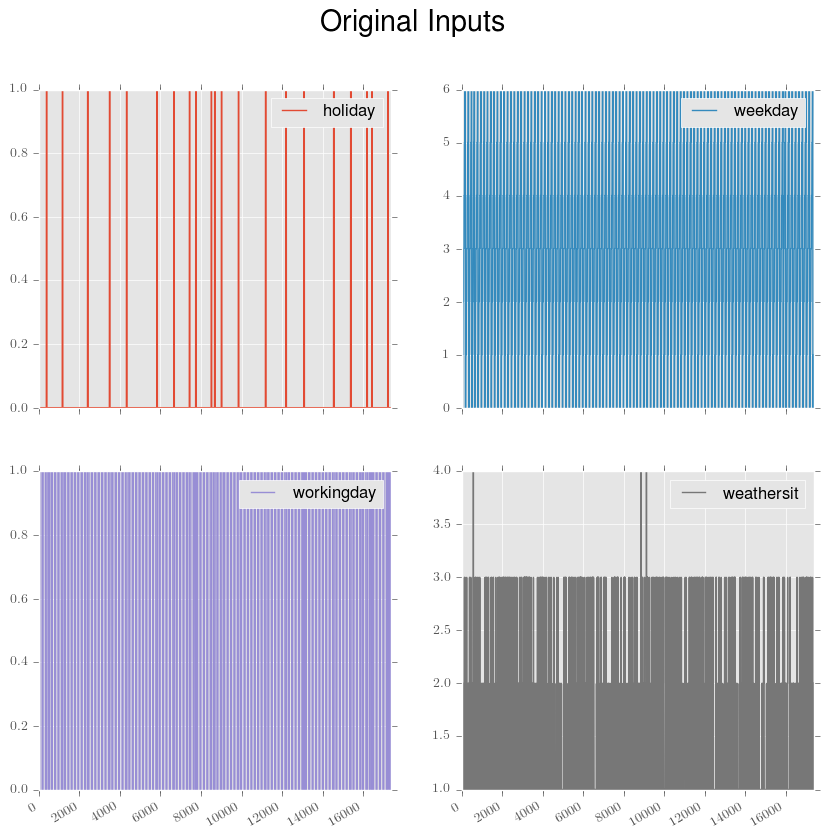

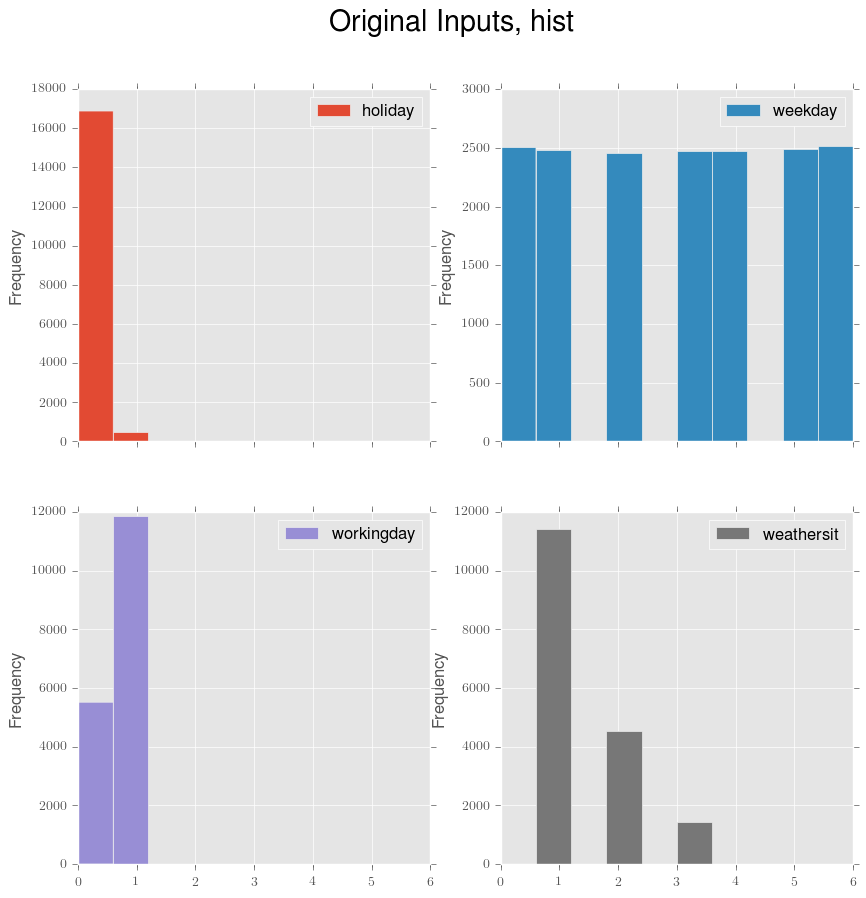

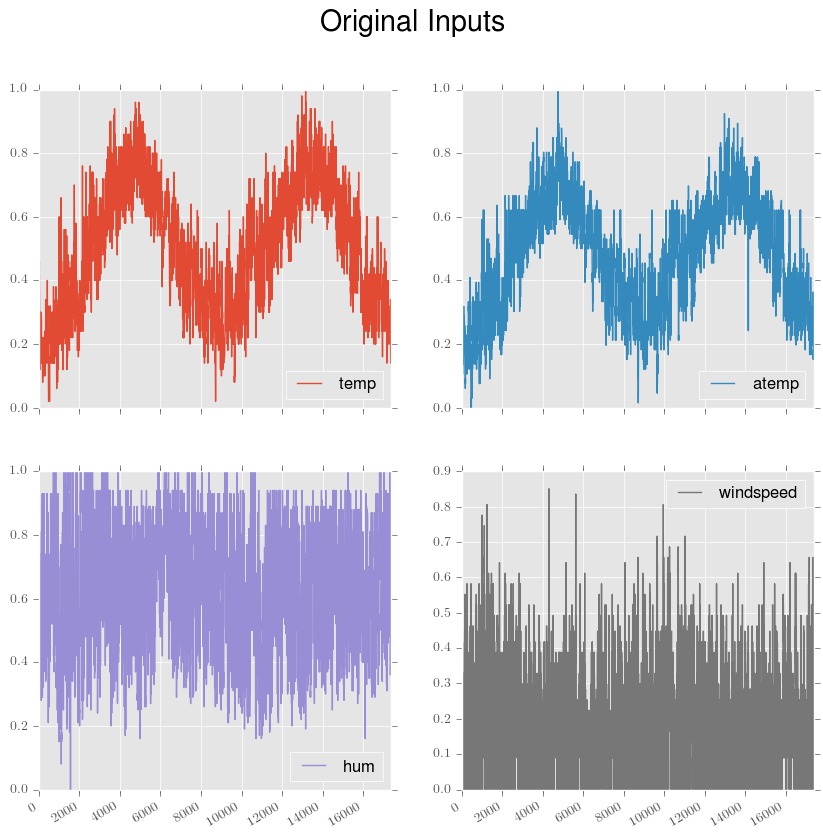

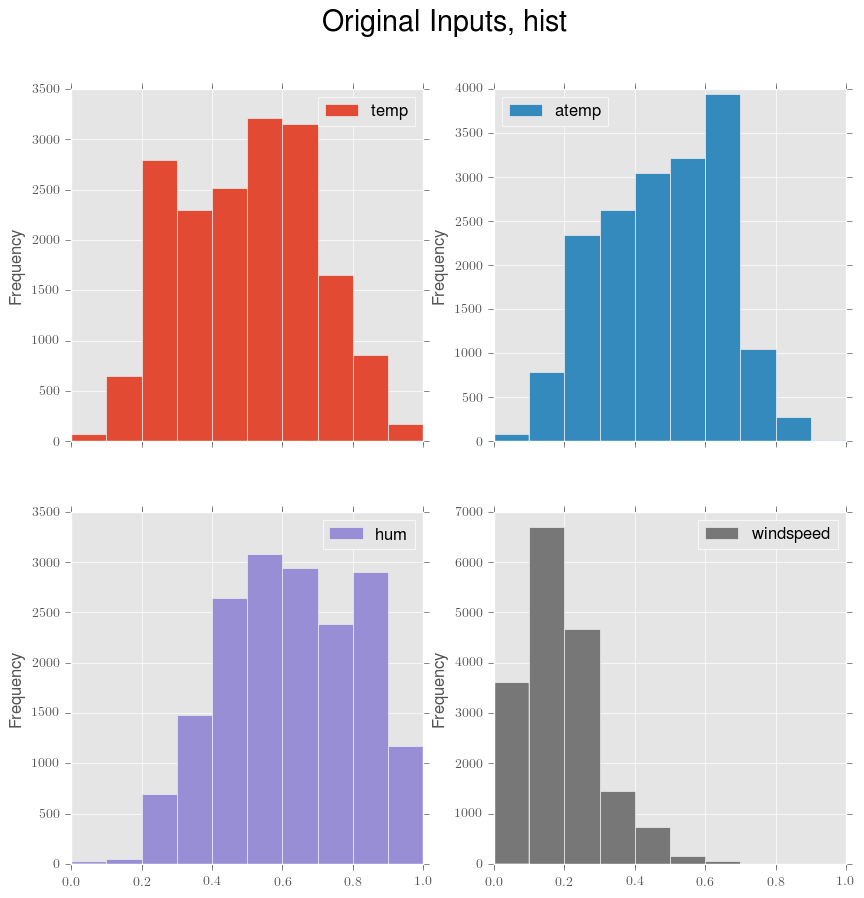

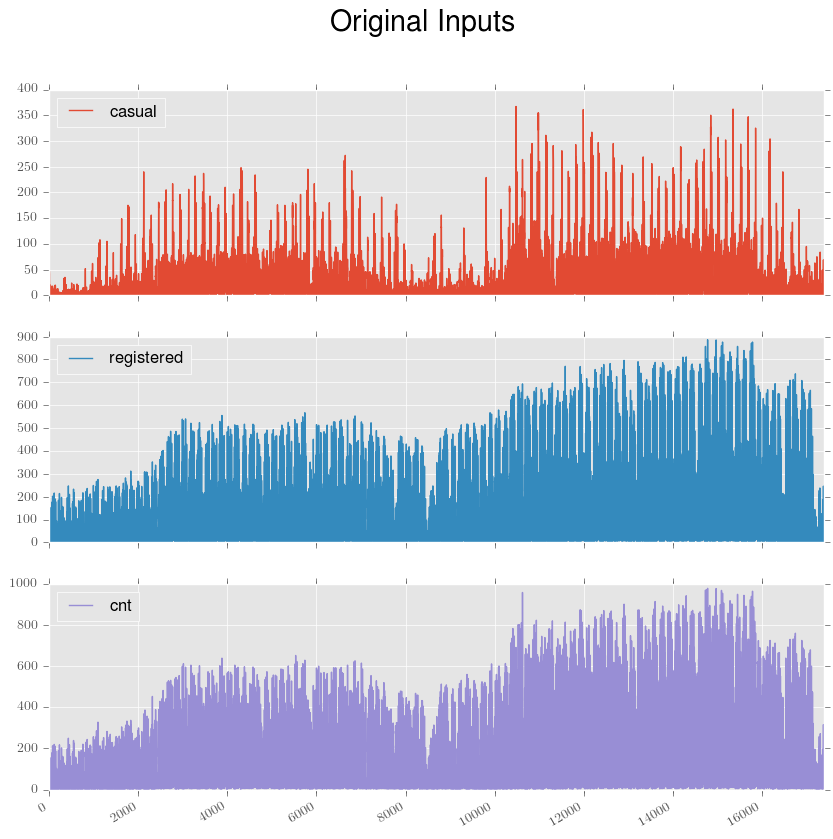

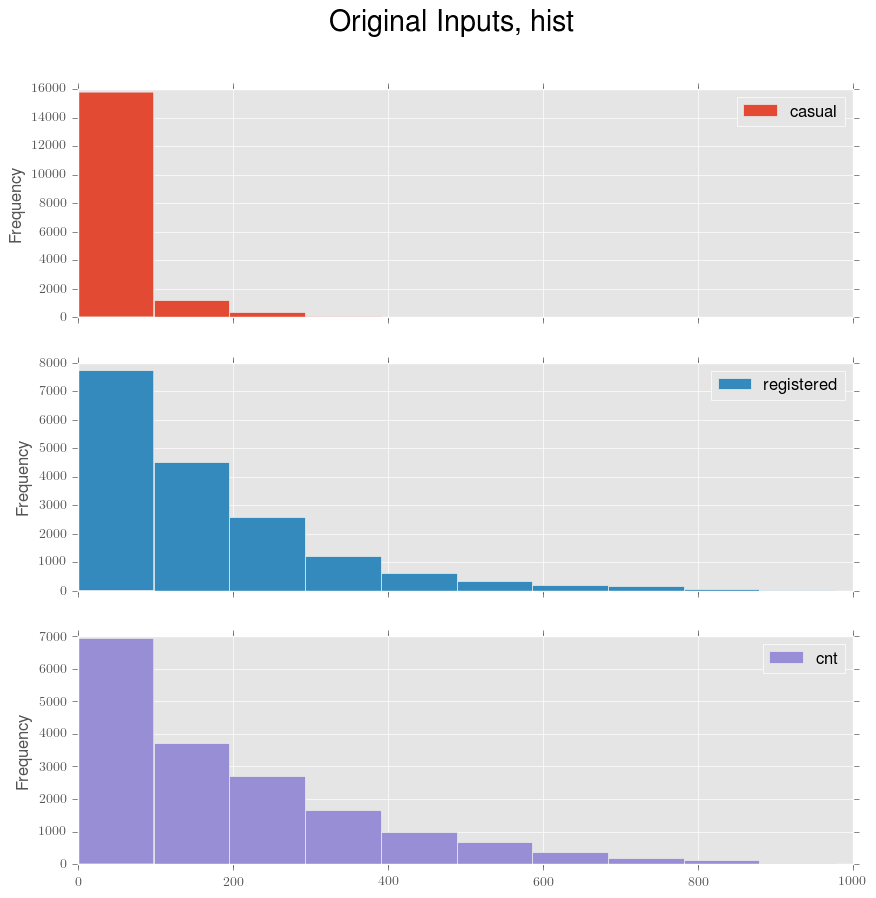

In [96]:
# default delimiter
df = pd.read_csv(input_file, header = 0)

# overview of original inputs

df[['season', 'yr', 'mnth', 'hr']].plot(subplots=True, layout=(2,2),title="\huge{Original Inputs}", figsize=(10,10))
df[['season', 'yr', 'mnth', 'hr']].plot.hist(subplots=True, layout=(2,2),title="\huge{Original Inputs, hist}", figsize=(10,10))
df[[ 'holiday','weekday', 'workingday', 'weathersit']].plot(subplots=True,layout=(2,2),title="\huge{Original Inputs}", figsize=(10,10))
df[[ 'holiday','weekday', 'workingday', 'weathersit']].plot.hist(subplots=True,layout=(2,2),title="\huge{Original Inputs, hist}", figsize=(10,10))
df[[ 'temp', 'atemp', 'hum','windspeed']].plot(subplots=True,layout=(2,2),title="\huge{Original Inputs}", figsize=(10,10))
df[[ 'temp', 'atemp', 'hum','windspeed']].plot.hist(subplots=True,layout=(2,2),title="\huge{Original Inputs, hist}", figsize=(10,10))
df[[ 'casual', 'registered', 'cnt']].plot(subplots=True,layout=(3,1),title="\huge{Original Inputs}", figsize=(10,10))
df[[ 'casual', 'registered', 'cnt']].plot.hist(subplots=True,layout=(3,1),title="\huge{Original Inputs, hist}", figsize=(10,10))



## Preparation of data <a class="anchor" id="preparation"></a>

This cell manipulates the inputs and prepares them for processing. In particular, the following steps are performed:

* Convert the dteday column in a numeric format. Since year and month are already stored in the dataset as separate column, I choose to keep only the day of the month.
* There are three possible target variables, representing the total number of users, the number of registered users and the number of casual users. I want to study the predictions for the three variable separately, so they are extracted from the dataset and stored as separate variables
* The features need to be extracted from the dataset. I choose to ignore instant, since it is redundant, once we know date and time. The day of the month (i.e. dteday) seems to me to be irrelevant for this particular problem: season, weather, and weekends/holidays are recorded in separate fields in the same dataset.
* I convert some of the features into categoricals, using get_dummy. This, together with interaction terms, may add some capacity to linear models
* I add 2nd degree interactions
* in the case of high dimensionality (i.e. with categoricals+interactions) I experiment with some feature selection: PCA, model-based
* In principle, the shapes of all the variables look good. The targets are, however, peaked at zero, which may pose some problems. I choose to transform them to log+1. This will reduce the range, as well as giving a more regular shape.
* Once the features have been defined, I choose to scale them, so one can also test algorithms that are not scale-invariant

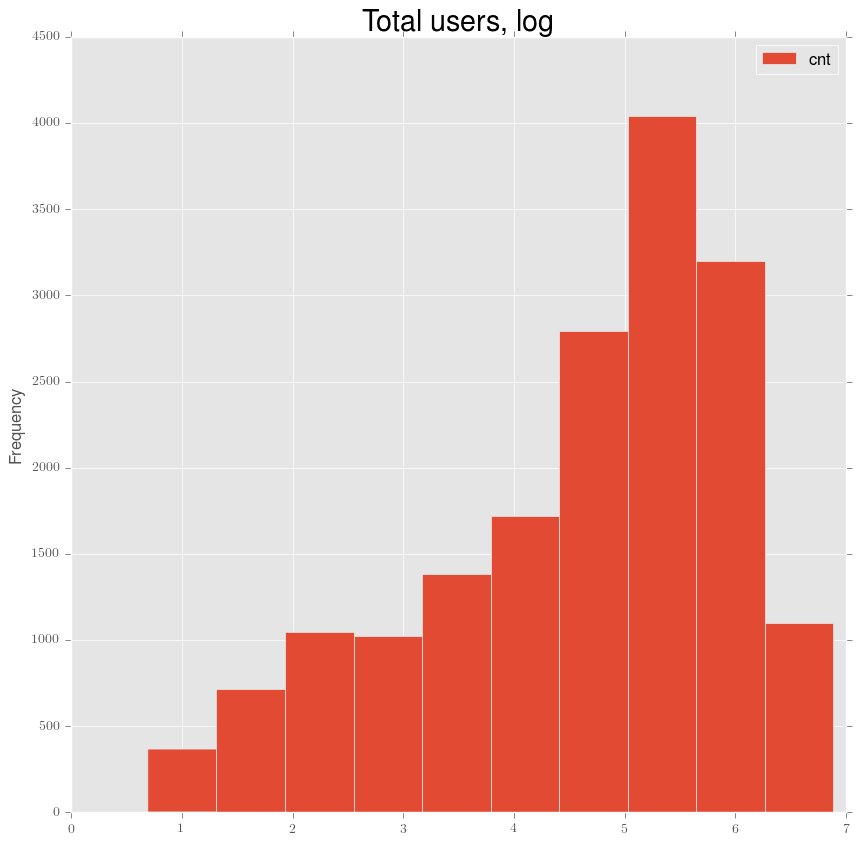

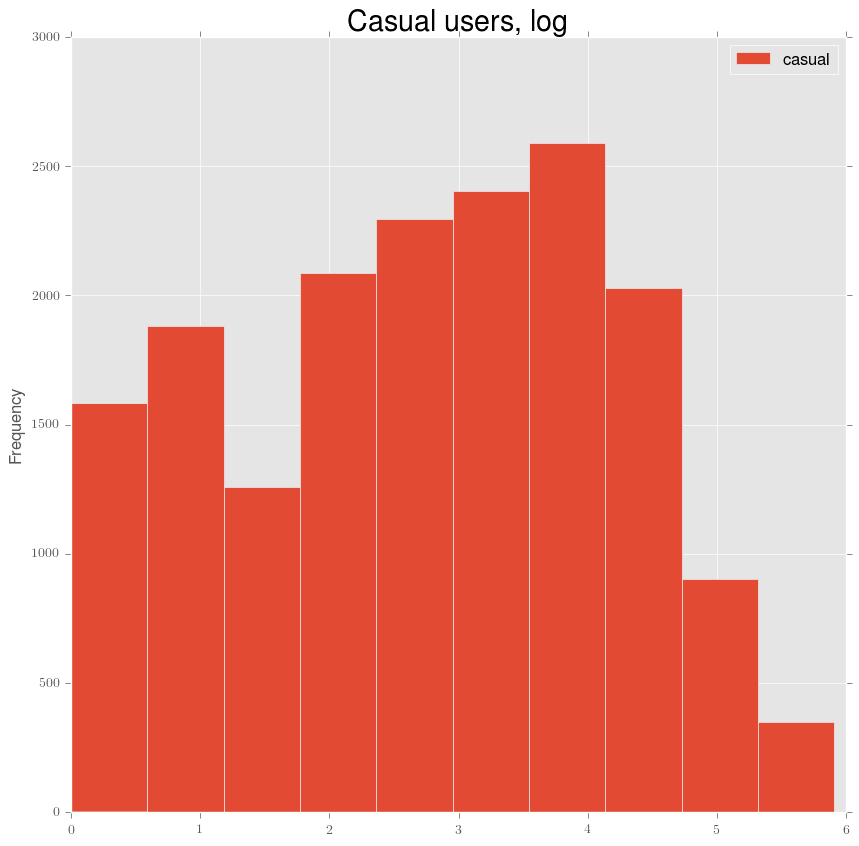

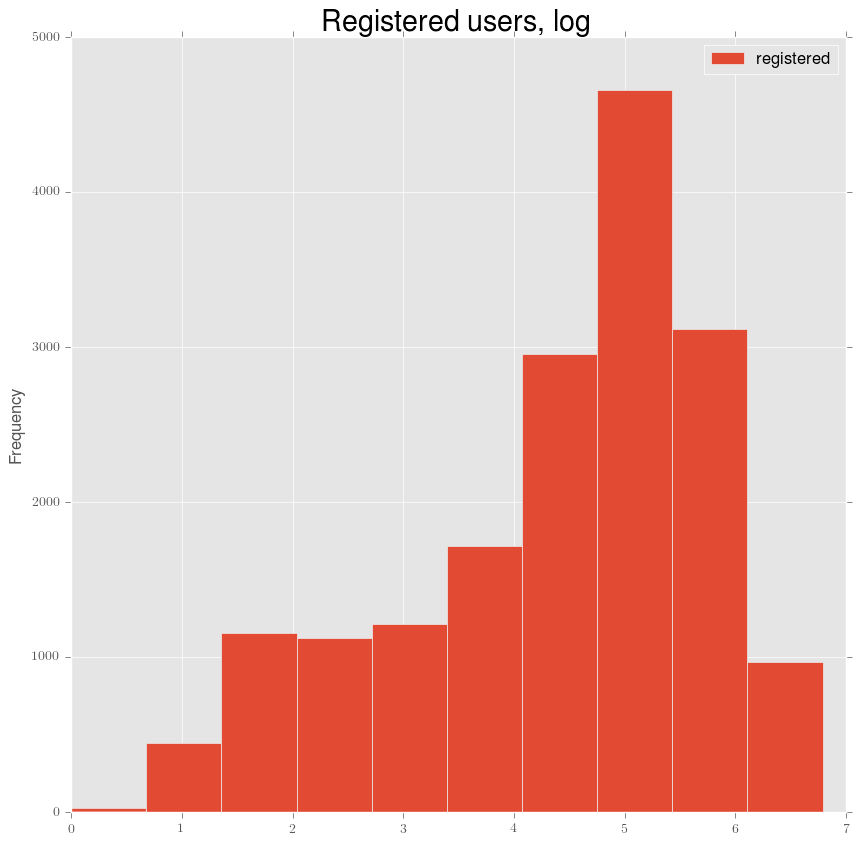

In [97]:
from sklearn.preprocessing import PolynomialFeatures

myX=defaultdict()
myX_scaled=defaultdict()

#this gives back the column names
original_headers = list(df.columns.values)

# tha date field has an annoying format, and month and year are redundant.
# let's turn it into an integer representing the day of the month

df['day']=df['dteday'].apply(lambda x: dt.datetime.strptime(str(x), "%Y-%m-%d").date().day)

# extract our target variables
myY=np.log(df[['cnt']]+1)
myYc=np.log(df[['casual']]+1)
myYr=np.log(df[['registered']]+1)


myY.plot.hist(title="\huge{Total users, log}", figsize=(10,10))
myYc.plot.hist(title="\huge{Casual users, log}", figsize=(10,10))
myYr.plot.hist(title="\huge{Registered users, log}", figsize=(10,10))


# extract the features. 'instant' has no real information, once we know date and time.

myX['plain']=df[[ column for column in list(df.columns.values) if column not in ['cnt' ,'dteday','instant','casual','registered'] ]]

# use OneHotEncoder for categorical variables. I prefer to use it column by column

myX['cat']=pd.get_dummies(myX['plain'],columns=['weekday','workingday','holiday','season','yr'])

# use polynomial features to add interactions

poly=PolynomialFeatures(degree=2,interaction_only=True,include_bias=False).fit(myX['cat'])
myX['int']=poly.transform(myX['cat'])
myX['int']=pd.DataFrame(myX['int'])
myX['int'].columns=list(myX['cat'].columns)+list(poly.get_feature_names()[len(myX['cat'].columns):])

# feature selection using PCA

myX['pca']=PCA(n_components=50,random_state=0).fit_transform(myX['int'].values)
myX['pca']=pd.DataFrame(myX['pca'])


# scale inputs, for models that are not scale-invariant

scaler = preprocessing.MinMaxScaler()

# scale inputs and put them back in a DF

for input in myX.keys():

    myX_scaled[input]=myX[input].values
    myX_scaled[input]=scaler.fit_transform(myX_scaled[input])
    myX_scaled[input]=pd.DataFrame(myX_scaled[input])
    myX_scaled[input].columns=myX[input].columns



## Check data after manipulation <a class="anchor" id="check"></a>

A few histograms to cross check that the inputs have not been inadvertently corrupted by the extraction/manipulation in the previous cells

[to top](#TOC)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff881b6e910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff881734710>]], dtype=object)

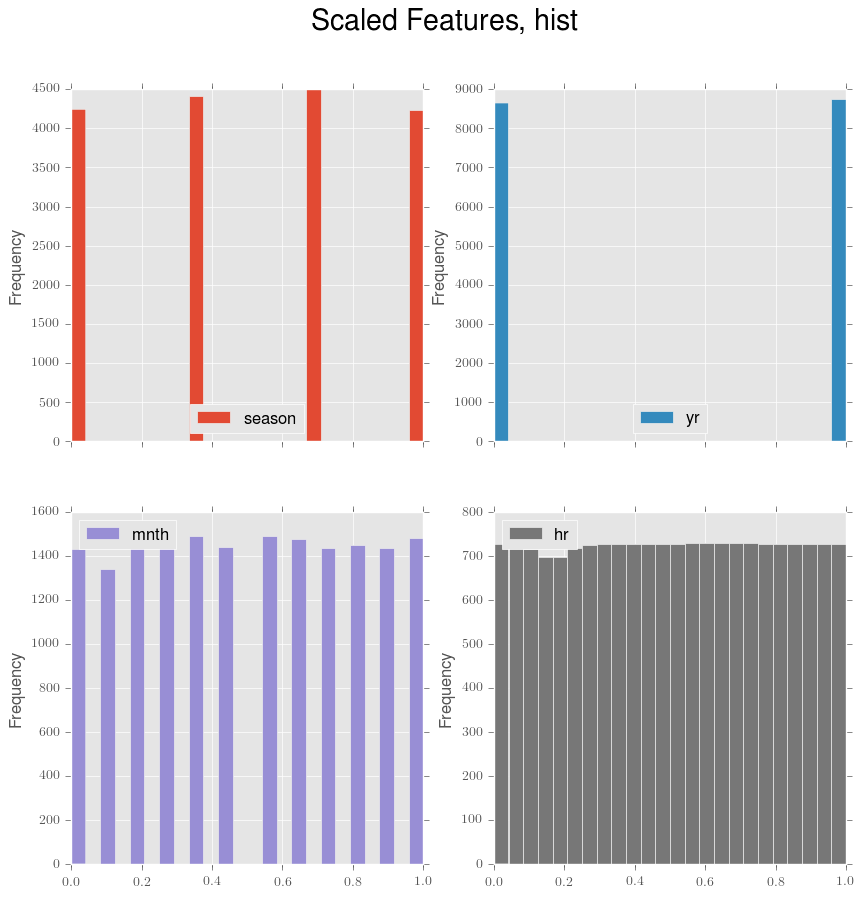

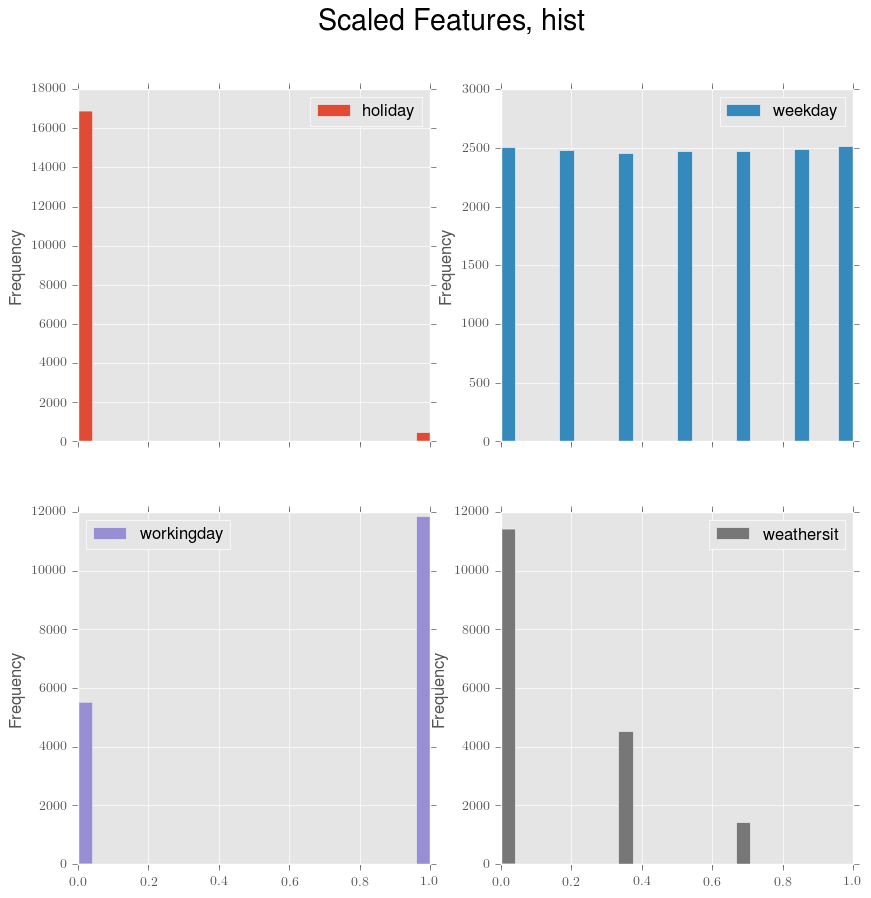

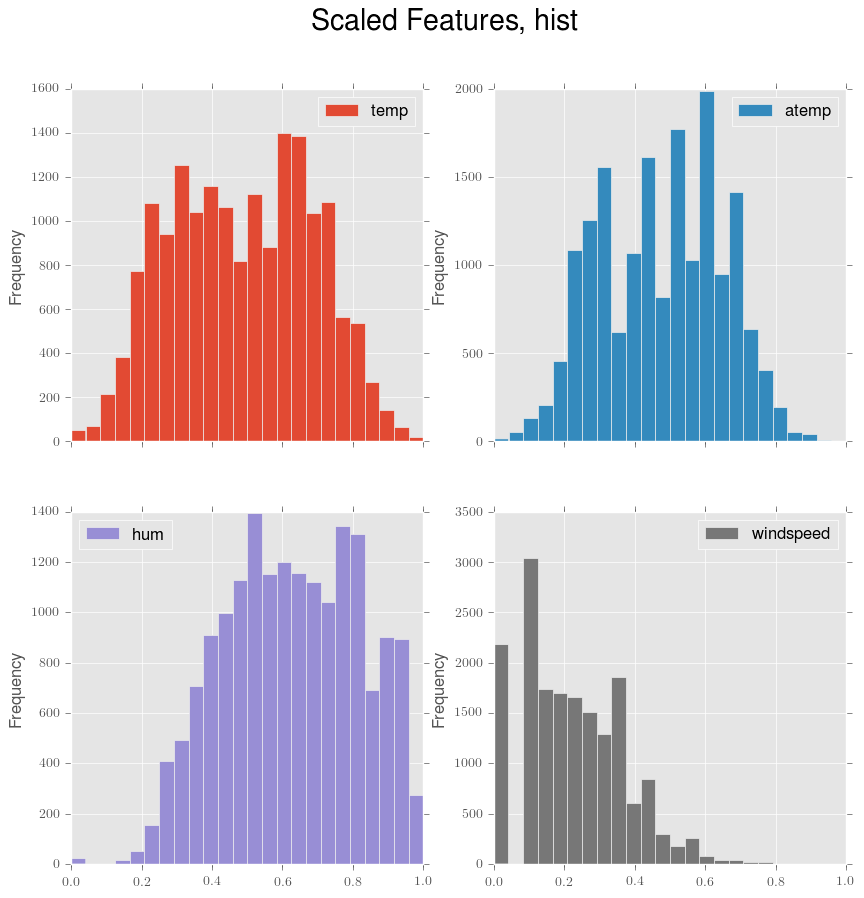

In [98]:


myX_scaled['plain'][['season', 'yr', 'mnth', 'hr']].plot.hist(subplots=True, layout=(2,2),title="\huge{Scaled Features, hist}",bins=24,figsize=(10,10))
myX_scaled['plain'][[ 'holiday','weekday', 'workingday', 'weathersit']].plot.hist(subplots=True,layout=(2,2),title="\huge{Scaled Features, hist}",bins=24,figsize=(10,10))
myX_scaled['plain'][[ 'temp', 'atemp', 'hum','windspeed']].plot.hist(subplots=True,layout=(2,2),title="\huge{Scaled Features, hist}",bins=24,figsize=(10,10))


## Creating training and test sets <a class="anchor" id="creating"></a>

The code splits the inputs in different test/training pairs with varying number of events. The loop runs on all fractions from 0.01 to the maximum defined in `max_percentage`, in steps of 0.01. To save some programming time, the built-in  `model_selection.train_test_split` is used for the splitting itself.
At the end of this cell, there will be one train/test pair for each desired training fraction.

[to top](#TOC)

In [99]:
fractions_test=[x*0.01 for x in range(1,max_percentage+1)]

myX_train=defaultdict(lambda: defaultdict() )
myX_test=defaultdict(lambda: defaultdict() )

#for input in myX.keys():
#    # init defaultdicts so we can use them in assignment
#    myX_train[input]=None
#    myX_test[input]=None

myY_train=dict()
myY_test=dict()
myYc_train=dict()
myYc_test=dict()
myYr_train=dict()
myYr_test=dict()

seed=0
# generate samples
for fraction in fractions_test:

    # prepare input tuple for train_test_split
    inputtuple=()    
    
    for indata in myX.keys():
        inputtuple=inputtuple+(myX[indata],)

    inputtuple=inputtuple+(myY, myYc, myYr)
            
    outputtuple = model_selection.train_test_split(*inputtuple,test_size=1-fraction, random_state=seed)
    
    # order in outputtuple is the same as order in myX.keys()
    
    for res in myX.keys():
        myX_train[res][fraction]=outputtuple[0]
        myX_test[res][fraction]=outputtuple[1]
        # pop values as they are extracted
        outputtuple=outputtuple[2:]
 
    # now assign features
    myY_train[fraction]=outputtuple[-6]
    myY_test[fraction]=outputtuple[-5]
    myYc_train[fraction]=outputtuple[-4]
    myYc_test[fraction]=outputtuple[-3]
    myYr_train[fraction]=outputtuple[-2]
    myYr_test[fraction]=outputtuple[-1]


# Model fitting <a class="anchor" id="model"></a>

The following code loops on the desired training fractions and on the configured models. For each fraction/model, three regressors are fitted: one for the total number of users, one for the number of registered users and one for the number of casual users.

After fitting the model, the mean absolute error is calculated (using the built-in `metrics.mean_absolute_error`). The scores defined for each algorithm are also evaluated.

Since the exercise requires to study in particular a training fraction of 10%, information corresponding to this step is saved for further inspection (the `target_*` variables).

The loop may take a few minutes, depending on how many models have been activated.

[to top](#TOC)

In [102]:

error=defaultdict(lambda: defaultdict(list))
errorc=defaultdict(lambda: defaultdict(list))
errorr=defaultdict(lambda: defaultdict(list))
errorsum=defaultdict(lambda: defaultdict(list))

train_error=defaultdict(lambda: defaultdict(list))
train_errorc=defaultdict(lambda: defaultdict(list))
train_errorr=defaultdict(lambda: defaultdict(list))
train_errorsum=defaultdict(lambda: defaultdict(list))

score=defaultdict(lambda: defaultdict(list))
scorec=defaultdict(lambda: defaultdict(list))
scorer=defaultdict(lambda: defaultdict(list))

# save here the predictions for the target training fraction
target_prediction=defaultdict(lambda: defaultdict(list))
target_predictionr=defaultdict(lambda: defaultdict(list))
target_predictionc=defaultdict(lambda: defaultdict(list))

# save here the fitted models
target_model=defaultdict(lambda: defaultdict())
target_modelr=defaultdict(lambda: defaultdict())
target_modelc=defaultdict(lambda: defaultdict())


# full inputs
inputs=myX.keys()
# selected inputs
#inputs=['pca']

# setup a simple progress bar

import sys
total_steps=len(inputs)*len(fractions_test)*len(models)
done_steps=0

# now  loop

for input in inputs:

    for fraction in fractions_test:

        for name,model in models.iteritems():

            # skip low-stat training for high-dim configurations
            if input=='plain' or (input =='cat' and fraction>0.05) or (input in['int','pca'] and fraction>=0.1):
                # use custom arguments
                themodel=model[0](** model[1])
                themodelc=model[0](** model[1])
                themodelr=model[0](** model[1])

                #print 'fitting a',name,'model with training fraction',fraction

                themodel.fit(myX_train[input][fraction], np.ravel(myY_train[fraction]))
                themodelc.fit(myX_train[input][fraction], np.ravel(myYc_train[fraction]))
                themodelr.fit(myX_train[input][fraction], np.ravel(myYr_train[fraction]))

                # cache results
                result= themodel.predict(myX_test[input][fraction])
                resultc=themodelc.predict(myX_test[input][fraction])
                resultr=themodelr.predict(myX_test[input][fraction])
                train_result= themodel.predict(myX_train[input][fraction])
                train_resultc=themodelc.predict(myX_train[input][fraction])
                train_resultr=themodelr.predict(myX_train[input][fraction])

                if fraction==0.1:
                    target_prediction[input][name]=result
                    target_predictionr[input][name]=resultr
                    target_predictionc[input][name]=resultc
                    target_model[input][name]= themodel
                    target_modelr[input][name]=themodelr
                    target_modelc[input][name]=themodelc

                error[input][name].append(metrics.mean_absolute_error(np.exp(result)-1,np.exp(np.ravel(myY_test[fraction]))-1))
                errorc[input][name].append(metrics.mean_absolute_error(np.exp(resultc)-1,np.exp(np.ravel(myYc_test[fraction]))-1))
                errorr[input][name].append(metrics.mean_absolute_error(np.exp(resultr)-1,np.exp(np.ravel(myYr_test[fraction]))-1))
                errorsum[input][name].append(metrics.mean_absolute_error(np.exp(resultc)+np.exp(resultr)-2, np.exp(np.ravel(myY_test[fraction]))-1))

                train_error[input][name].append(metrics.mean_absolute_error(np.exp(train_result)-1,np.exp(np.ravel(myY_train[fraction]))-1))
                train_errorc[input][name].append(metrics.mean_absolute_error(np.exp(train_resultc)-1,np.exp(np.ravel(myYc_train[fraction]))-1))
                train_errorr[input][name].append(metrics.mean_absolute_error(np.exp(train_resultr)-1,np.exp(np.ravel(myYr_train[fraction]))-1))
                train_errorsum[input][name].append(metrics.mean_absolute_error(np.exp(train_resultc)+np.exp(train_resultr)-2, np.exp(np.ravel(myY_train[fraction]))-1))

                score[input][name].append(themodel.score(myX_test[input][fraction].as_matrix(), np.ravel(myY_test[fraction])))
                scorec[input][name].append(themodelc.score(myX_test[input][fraction].as_matrix(), np.ravel(myYc_test[fraction])))
                scorer[input][name].append(themodelr.score(myX_test[input][fraction].as_matrix(), np.ravel(myYr_test[fraction])))

            else:
                    
                error[input][name].append(np.nan)
                errorc[input][name].append(np.nan)
                errorr[input][name].append(np.nan)
                errorsum[input][name].append(np.nan)

                train_error[input][name].append(np.nan)
                train_errorc[input][name].append(np.nan)
                train_errorr[input][name].append(np.nan)
                train_errorsum[input][name].append(np.nan)

                score[input][name].append(np.nan)
                scorec[input][name].append(np.nan)
                scorer[input][name].append(np.nan)

                
            done_steps+=1

            # update progress 

            sys.stdout.write("\r %i %% done" % (100.*done_steps/total_steps))
            sys.stdout.flush()
                
                

 26 % done

/home/disimone/.local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


 100 % done

# Inspection of results <a class="anchor" id="inspection"></a>

The following cell creates some plots and tables to understand the performance of the fitted models. For each model, the same set of plots are created:

* For linear regression models, the coefficients are printed, to provide some guidance concerning feature ranking
* Only for the 10% training fraction, residual plots show the difference (prediction-true value) versus the true value. This is shown for the three different targets (total number of users, registered users, casual users). The direct prediction for the total number of users is compared to the sum of the two separate predictions for casual and registered users.
* For all studied training fractions, the mean absolute error is plotted as a function of the training fraction. Again, the performance for the total number of users is compared to the one one would get when adding the two separate predictions for casual and registered users.

[to top](#TOC)

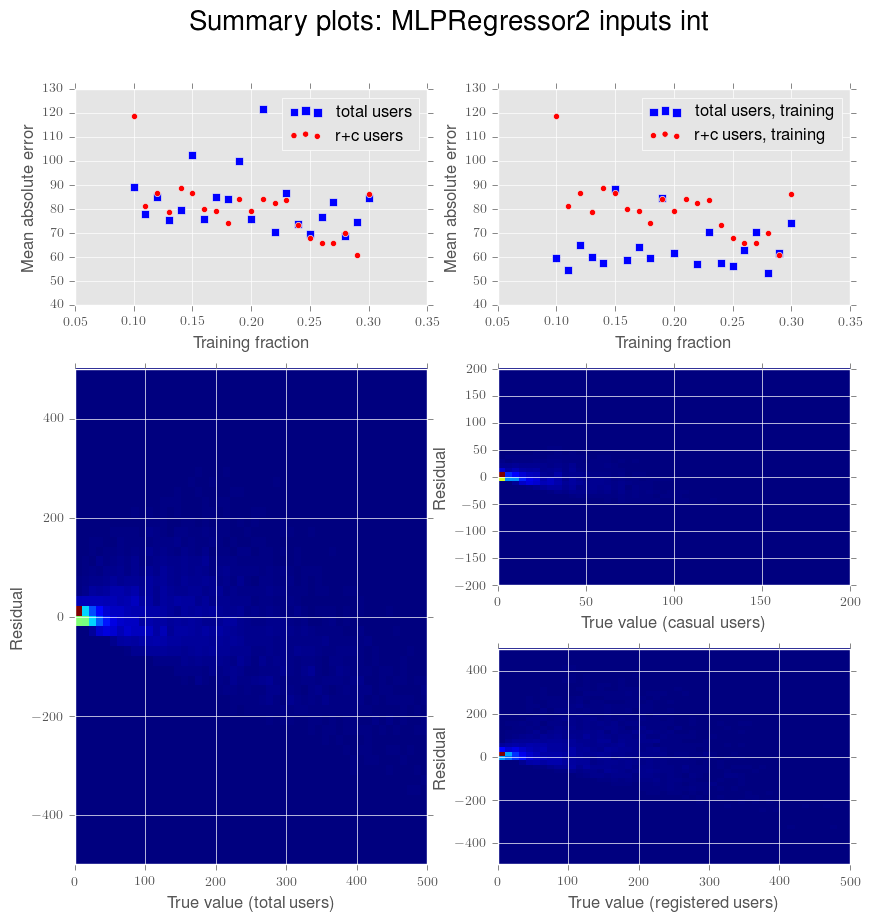

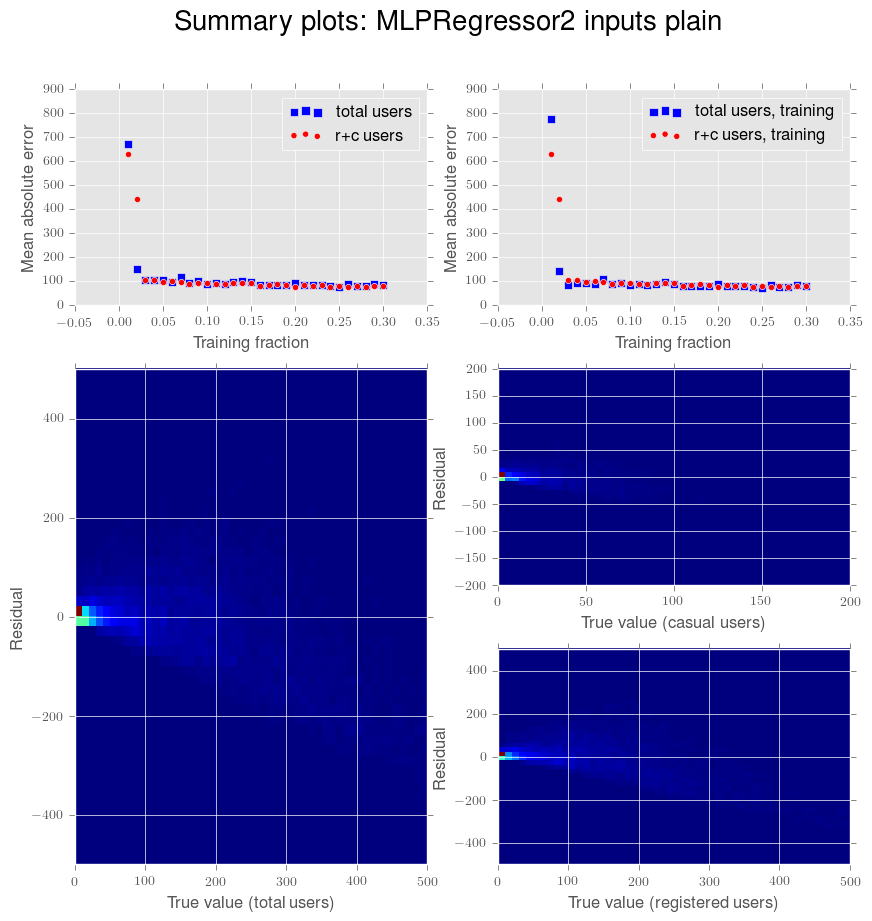

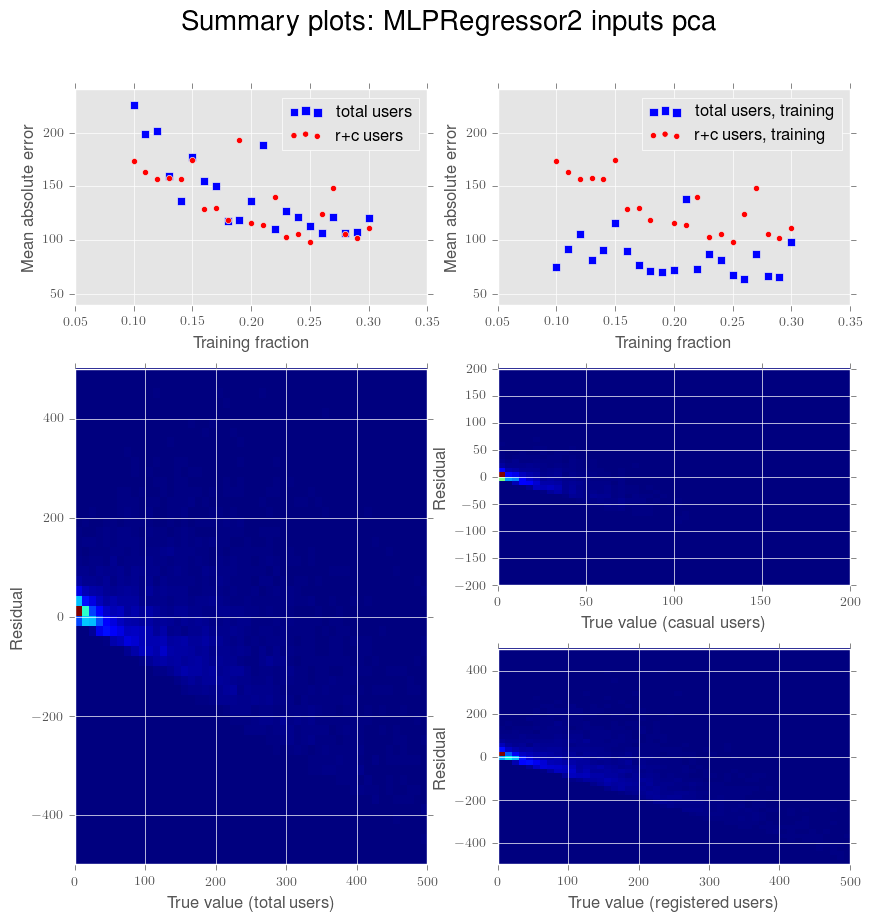

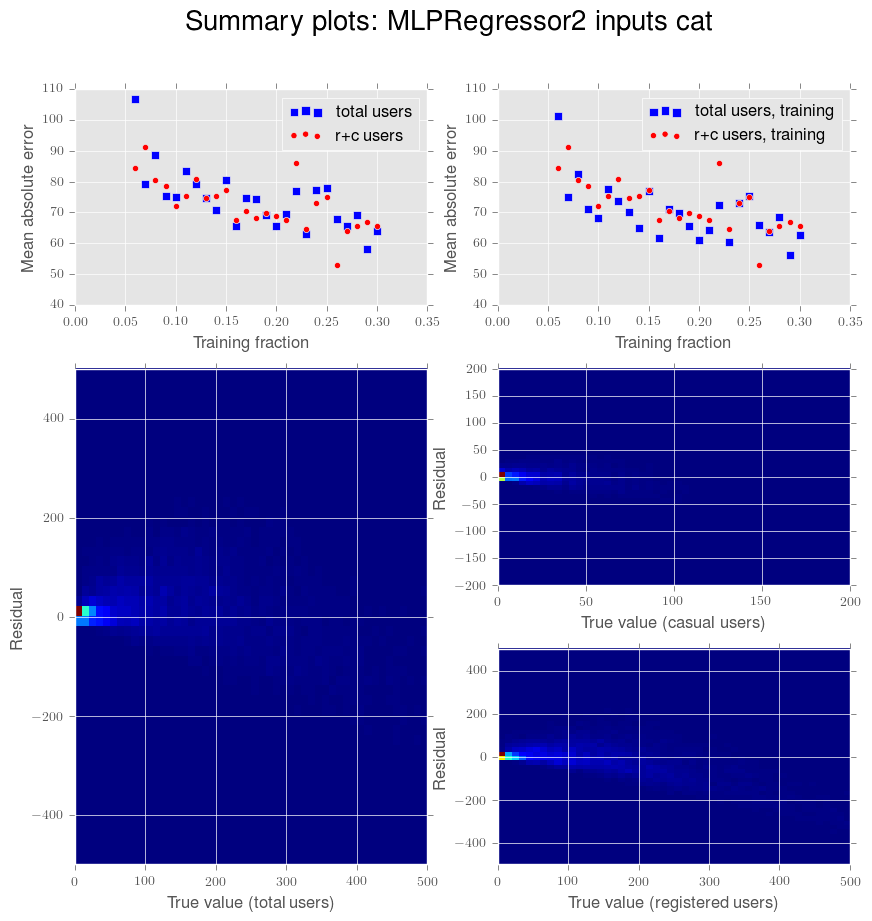

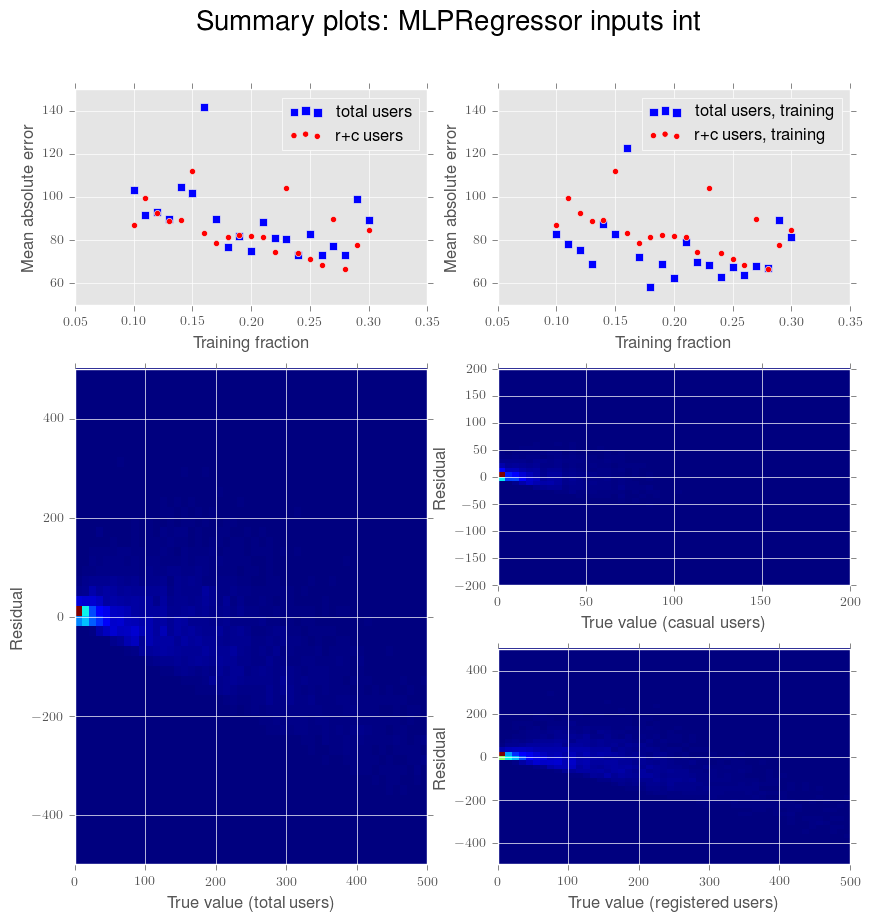

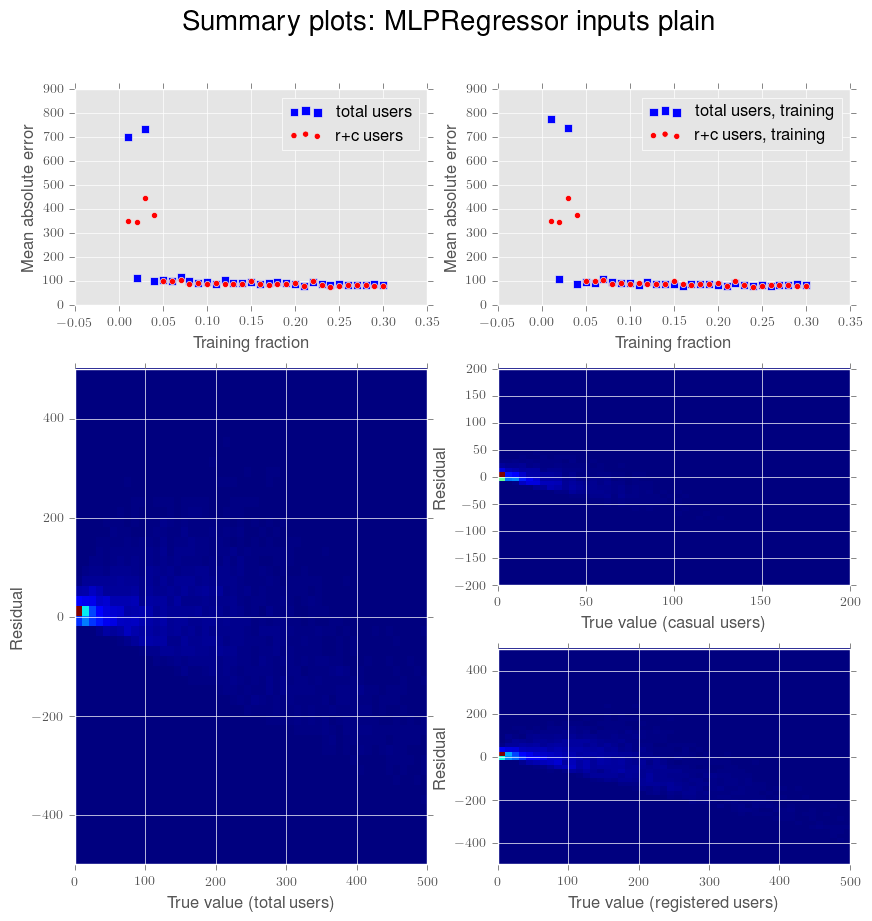

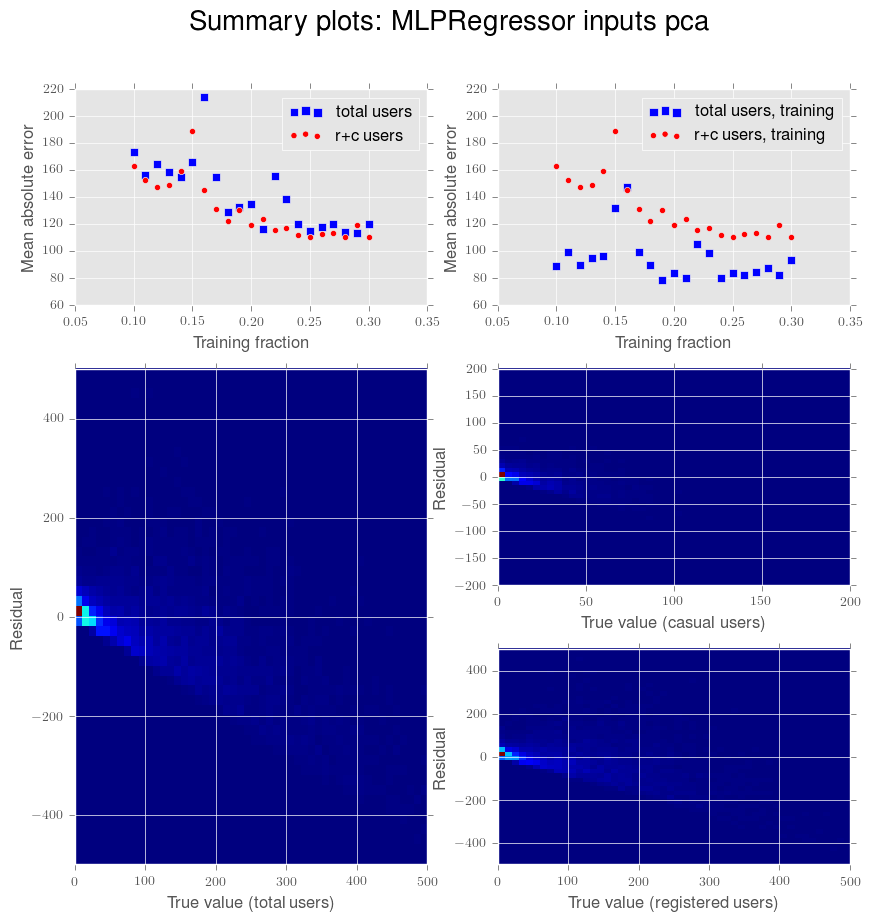

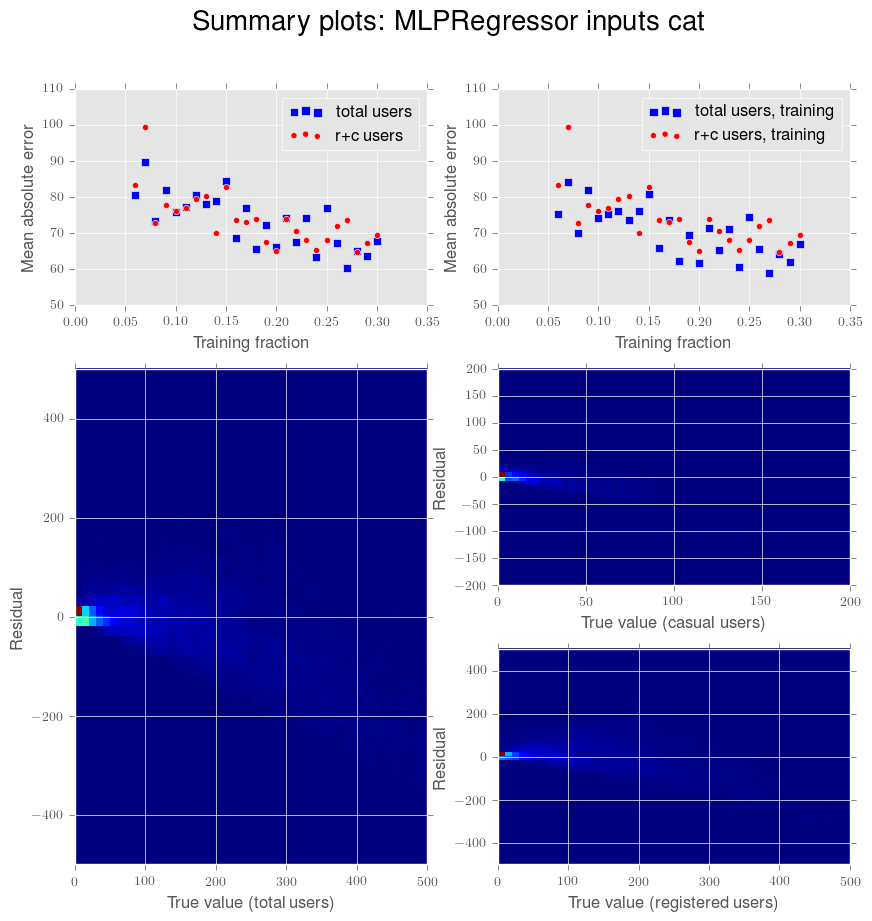

In [103]:
for name in models.keys():

    for input in inputs:
            
        # inspect feature ranking

        if name=='Linear Regression' or name=='Ridge':

        
            lincoeff=pd.DataFrame(zip(myX_test[input][0.1].columns, target_model[input][name].coef_,target_modelc[input][name].coef_,target_modelr[input][name].coef_),columns=['feature','coefficient (total)',"coefficient (registered)", "coefficient (casual)"])
            print '\n Coefficients for', name,'with input',input,'\n'
            display(lincoeff)
            
        figres=plt.figure(figsize=(10,10))
        figres.canvas.set_window_title(name)
        figres.suptitle("Summary plots: "+name+" inputs "+input,fontsize=20)
        plt.subplots_adjust(hspace = .3)
    
        subres_0=plt.subplot2grid((3,2),(0,0))
        subres_0.scatter(fractions_test,error[input][name],label="total users",marker='s',s=40,c='b')
        subres_0.scatter(fractions_test,errorsum[input][name],label="r+c users",marker='o',s=20,c='r')
        subres_0.set_ylabel('Mean absolute error')
        subres_0.set_xlabel('Training fraction')
        plt.legend(loc='best');

        subres_0_1=plt.subplot2grid((3,2),(0,1))
        subres_0_1.scatter(fractions_test,train_error[input][name],label="total users, training",marker='s',facecolor='none',s=40,c='b')
        subres_0_1.scatter(fractions_test,errorsum[input][name],label="r+c users, training",marker='o',facecolor='none',s=20,c='r')
        subres_0_1.set_ylabel('Mean absolute error')
        subres_0_1.set_xlabel('Training fraction')
        plt.legend(loc='best');

        # use same scale for training and test errors
        
        ylim1=subres_0.get_ylim()
        ylim2=subres_0_1.get_ylim()
        ylimbest=min(ylim1[0],ylim2[0]),max(ylim1[1],ylim2[1])
        subres_0.set_ylim(ylimbest)
        subres_0_1.set_ylim(ylimbest)

        subres_1=plt.subplot2grid((3,2),(1,0),rowspan=2)
        subres_1.hist2d(np.exp(np.ravel(myY_test[0.1]))-1,np.exp(target_prediction[input][name])-np.exp(np.ravel(myY_test[0.1])),bins=(50,50),range=((0,500),(-500,500)),cmap=plt.cm.jet)
        subres_1.set_xlabel('True value (total users)')
        subres_1.set_ylabel('Residual')

        subres_2=plt.subplot2grid((3,2),(1,1))
        subres_2.hist2d(np.exp(np.ravel(myYc_test[0.1]))-1,np.exp(target_predictionc[input][name])-np.exp(np.ravel(myYc_test[0.1])),bins=(50,50),range=((0,200),(-200,200)),cmap=plt.cm.jet)
        subres_2.set_xlabel('True value (casual users)')
        subres_2.set_ylabel('Residual')
    
        subres_3=plt.subplot2grid((3,2),(2,1))
        subres_3.hist2d(np.ravel(np.exp(myYr_test[0.1]))-1,np.exp(target_predictionr[input][name])-np.exp(np.ravel(myYr_test[0.1])),bins=(50,50),range=((0,500),(-500,500)),cmap=plt.cm.jet)
        subres_3.set_xlabel('True value (registered users)')
        subres_3.set_ylabel('Residual')
    


                    


# Comments  <a class="anchor" id="comments"></a>

* **KNeighboursRegressor**:
   * The mean absolute error shows a very regular behavior as a function of the training fraction, quite similar to a power law, as one would expect from a progressive increase of the density of neighbours (i.e. increased precision of the interpolation).
   * There does not appear to be any significant gain in predicting the total users starting from the two seaparate components (registered/casual).
   * While the mean absolute error for a 10% training fraction is around 85, the residual plot shows that the residuals tend to be significantly larger for larger number of total users. This is moslty due to the registered users (which is, on the other hand, the dominant component of the total users)
* **LinearRegression, Ridge**
   * The two linear models perform in an overall comparable way. The absolute mean error is stable above a 10% training training fraction
   * No gain is observed by splitting the total users in the two components
   * In the residual plots it is here even more evident that for large numbers of users, the prediction is systematically lower than the true value
   * Inspection of the coefficients of the models reveals that:
      * The `weathersit` feature is only weakly correlated to the registered users, while it is anti-correlated to the casual users, which seems to suggest that registered users are those who bike because they have to, e.g. to commute to work. This seems to agree with what seen for other weather-related features (like `atemp`, `hum`, `windspeed`)
      * This is confirmed by the very strong correlation of `season` with the casual users, which is not true in the case of the registered users, and by the oppite-sign correlation of `holiday` with registered and casual users
* **SVR**
   * This model, while not performing as good as the linear models or the KNeighboursRegressor, shows a significant improvement when predicting the registered and casual users separately, which may be worth a longer investigation, maybe trying different configurations of the algorithm
   * The residuals for the registered users are strongly correlated with the true value, mush more strongly than observed for the other models, which may be one of the reasons for the sub-optimal performance in terms of mean absolute error
* **MLPRegressor**
   * This model still shows some improvements from the splitting of the total users in registered and casual users, and reaches performances comparable to the linear models, with no worse-looking residual plots
   
[to top](#TOC)